In [1]:
cd drive_stats_2019_Q1/

/home/unburied/Gitstuff/DS-Unit-2/DS-Unit-2-Project/drive_stats_2019_Q1


In [2]:
from glob import glob
import pandas as pd

#read last week of march files into single list of dfs
data = [pd.read_csv(file) for file in glob('2019-03-2*')]

#concat all data and resetindex
data = pd.concat(data).reset_index(drop = True)

In [3]:
data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2019-03-28,Z305B2QN,ST4000DM000,4000787030016,0,117.0,149764472.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-03-28,ZJV0XJQ4,ST12000NM0007,12000138625024,0,82.0,147493088.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-28,ZJV0XJQ3,ST12000NM0007,12000138625024,0,74.0,26118312.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-28,ZJV0XJQ0,ST12000NM0007,12000138625024,0,73.0,20223248.0,NaN,NaN,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-28,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,134.0,103.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Baseline
data.failure.value_counts(normalize = True)

0    0.99995
1    0.00005
Name: failure, dtype: float64

In [7]:
#determine number of unique models in data
print(f'There are {data.model.nunique()} unique model types')

There are 41 unique model types


In [8]:
#Determine how many models in this data have failed
failing_models = data[data.failure == 1]['model']

print(f'There are {failing_models.nunique()} model types that have failed')

There are 9 model types that have failed


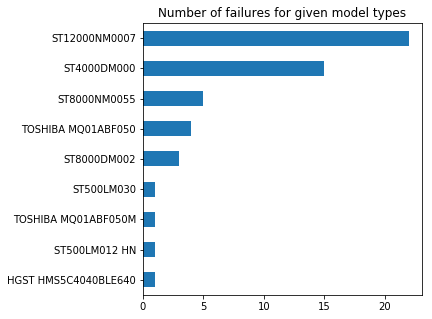

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,5))

#plot the model types that have failed
ax = failing_models.value_counts(ascending = True).plot.barh()
ax.set_title('Number of failures for given model types')
plt.savefig('model_failures.png')
plt.show();

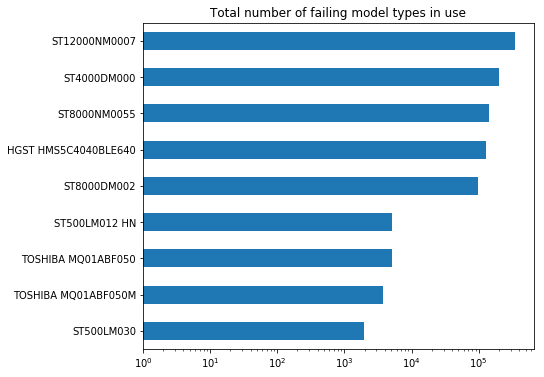

In [17]:
#filter for models that have failed
failed_models_total = data[data.model.isin(failing_models)]

fig = plt.figure(figsize = (7,6))

#plot totals for the model types that have failed
ax = failed_models_total.model.value_counts(ascending = True).plot.barh(log= True)
ax.set_title('Total number of failing model types in use')
plt.savefig('number_of_failing_models.png')
plt.show();

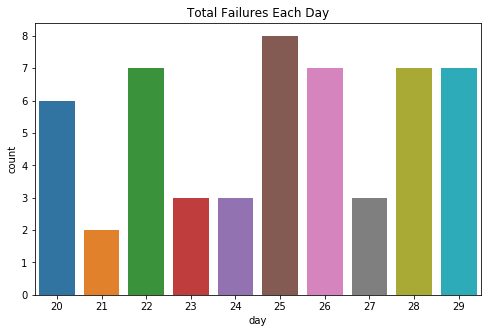

In [19]:
import seaborn as sns

#get failures only and add day time feature
failures = data[data.failure == 1].copy()
failures['day'] = pd.to_datetime(failures.date).dt.day

fig = plt.figure(figsize = (8,5))

#plot total hardrives failed each day
ax = sns.countplot(failures.day)
ax.set_title('Total Failures Each Day')
plt.savefig('daily_failures.png')
plt.show();

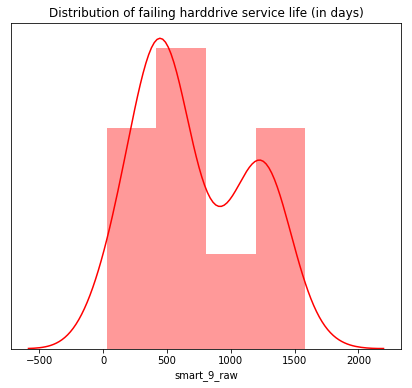

In [46]:
#filter for models that have failed
smart_9_failures = data[data.failure == 1]['smart_9_raw']

fig = plt.figure(figsize = (7,6))


#plot totals for the model types that have failed
ax = sns.distplot(smart_9_failures/ 24, color = 'r') 
ax.set_title('Distribution of failing harddrive service life (in days)')
ax.set_yticks([])
plt.savefig('days_before_a_model_fails.png')
plt.show();

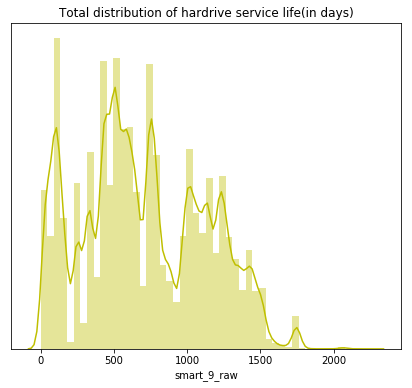

In [47]:
#filter for models that have failed
smart_9 = data['smart_9_raw'].fillna(data.smart_9_raw.mean())

fig = plt.figure(figsize = (7,6))

#plot totals for the model types that have failed
ax = sns.distplot(smart_9 / 24, color = 'y')
ax.set_title('Total distribution of hardrive service life(in days)')
ax.set_yticks([])
plt.savefig('life_distribution.png')
plt.show();

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import resample

import numpy as np
import category_encoders as ce

In [49]:
#data is daily status of the same harddrives, so set up variable
#to split on the unique hardrives in the dataset
serial_numbers = data['serial_number'].unique().tolist()

serial_failures = data[data.failure == 1]['serial_number'].unique().tolist()

for fail in serial_failures:
    serial_numbers.remove(fail)

#split on serial numbers
X_train_ids, X_test_ids = train_test_split(serial_numbers, random_state = 42)
X_train_ids, X_val_ids = train_test_split(X_train_ids,random_state = 42)

extend_train, extend_test = train_test_split(serial_failures, random_state = 42, train_size = .9)
extend_train,extend_val = train_test_split(extend_train, random_state = 42, train_size = .9)

X_train_ids.extend(extend_train)
X_val_ids.extend(extend_val)
X_test_ids.extend(extend_test)

#wrangle feature matrix
drop = ['serial_number']

#ensure train set has no failures to more acurately predict failure
X_train = data[data.serial_number.isin(X_train_ids)].drop(columns = drop)
X_test = data[data.serial_number.isin(X_test_ids)].drop(columns = drop)
X_val = data[data.serial_number.isin(X_val_ids)].drop(columns = drop)

#target vector
y_train = X_train.pop('failure')
y_test = X_test.pop('failure')
y_val = X_val.pop('failure')

/home/unburied/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [50]:
print('Fialures distributed among cross validation sets:')
print()
print(f'Training --> {y_train.value_counts()}')
print()
print(f'Validation --> {y_val.value_counts()}')   
print()
print(f'Testing --> {y_test.value_counts()}')   

Fialures distributed among cross validation sets:

Training --> 0    598622
1        42
Name: failure, dtype: int64

Validation --> 0    199597
1         5
Name: failure, dtype: int64

Testing --> 0    266068
1         6
Name: failure, dtype: int64


In [51]:
#Replace time string data with dattime date of year data
X_train['day'] = pd.to_datetime(X_train.date).dt.dayofyear.drop(columns = 'date')   
X_val['day'] = pd.to_datetime(X_val.date).dt.dayofyear.drop(columns = 'date') 
X_test['day'] = pd.to_datetime(X_test.date).dt.dayofyear.drop(columns = 'date') 

#encode models column
encoder = ce.OrdinalEncoder()

X_train  = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_val = encoder.transform(X_val)


#impute NAs. This may or may not be right
imputer = SimpleImputer()

X_train  = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
X_val = imputer.transform(X_val)

In [53]:
#def adaboost(X_train, X_val, y_train):
#    model = AdaBoostClassifier(n_estimators= 100, random_state=42)
#    model.fit(X_train,y_train)
#    y_pred = model.predict(X_val) 
#    return y_pred

#def isoforest(X_train, X_val, y_train):
#    model = IsolationForest(behaviour = 'new',
#                            contamination = .01,
#                            n_estimators=100,
#                           random_state=42)
#    model.fit(X_train,y_train)
#    y_pred = model.predict(X_val) 
#    return y_pred

In [ ]:
#Simple Random Undersampling technique
#X_full = pd.DataFrame(X_train)
#X_full['target'] = y_train
#X_maj = X_full[X_full.target==0]
#X_min = X_full[X_full.target==1]
#X_maj_rus = resample(X_maj,replace=False,n_samples= len(X_min), random_state=42)
#X_rus = pd.concat([X_maj_rus, X_min])
#X_train_rus = X_maj_rus.drop(['target'], axis=1)
#y_train_rus = X_maj_rus.target

In [ ]:
#y_rus = adaboost(X_train_rus, X_val, y_train_rus)
#y_if = isoforest(X_train_rus,X_val, y_train_rus)

In [ ]:
#print(classification_report(y_val, y_rus))
#print(classification_report(y_val, y_if))

In [ ]:
#print(roc_auc_score(y_val, y_rus))
#roc_auc_score(y_val, y_if)

In [55]:
cd

/home/unburied


In [56]:
cd Gitstuff/DS-Unit-2/DS-Unit-2-Project/imbalanced-algorithms

/home/unburied/Gitstuff/DS-Unit-2/DS-Unit-2-Project/imbalanced-algorithms


In [57]:
#import rus
import smote

In [ ]:
#Boosted RUS
#rus_boosted = rus.RUSBoost(n_samples = 500,
#                           with_replacement= False,
#                           random_state= 42)
#rus_boosted.fit(X_train, y_train)
#y_rus_boosted = rus_boosted.predict(X_val)

#print(classification_report(y_val, y_rus_boosted))

In [ ]:
#roc_auc_score(y_val, y_rus_boosted)

In [58]:
#Boosted smote
smote_boosted = smote.SMOTEBoost(n_samples = 500,                           
                           random_state= 42)
smote_boosted.fit(X_train, y_train)
y_smote_boosted = smote_boosted.predict(X_val)

print(classification_report(y_val, y_smote_boosted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199597
           1       0.03      0.40      0.06         5

   micro avg       1.00      1.00      1.00    199602
   macro avg       0.51      0.70      0.53    199602
weighted avg       1.00      1.00      1.00    199602



In [59]:
roc_auc_score(y_val, y_smote_boosted)

0.6998371719013813

In [68]:
y_smote_pred = smote_boosted.predict(X_test)
roc_auc_score(y_test, y_smote_test)

0.5831191023848541

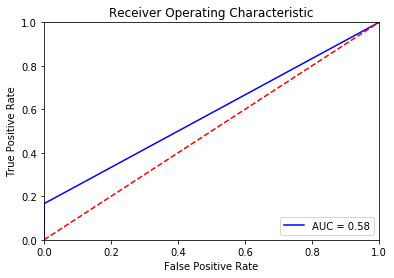

In [71]:
fpr, tpr, threshold = roc_curve(y_test, y_smote_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Auc.png')
plt.show()